# pynucastro usage examples

This notebook illustrates some of the higher-level data structures in `pynucastro`.

Note to run properly, you install pynucastro via:

```
python setup.py install
```

(optionally with ``--user``)

In [1]:
import pynucastro as pyna

## Examining a single rate

There are several ways to load a single rate.  If you down load the specific rate file from the JINA ReacLib website, then you can load the rate via `load_rate()` and
just giving that file name, e.g.,
```
c13pg = pyna.load_rate("c13-pg-n14-nacr")
```

However, an easier way to do this is to pass in the shorthand name for the rate to a library.  Here we'll read in the entire ReacLib library
and get the ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ rate.  The result will be a `Rate` object (or an object of a class derived from `Rate`). There are a lot of methods in the `Rate` class that allow you to explore the rate.

In [2]:
rl = pyna.ReacLibLibrary()
c13pg = rl.get_rate_by_name("c13(p,g)n14")

A `Rate` can display itself nicely

In [3]:
c13pg

C13 + p ⟶ N14 + 𝛾

### the original reaclib source

we can easily see the original source from ReacLib

In [4]:
print(c13pg.original_source)

4
         p  c13  n14                       nacrr     7.55100e+00          
 1.518250e+01-1.355430e+01 0.000000e+00 0.000000e+00                      
 0.000000e+00 0.000000e+00-1.500000e+00                                   
4
         p  c13  n14                       nacrn     7.55100e+00          
 1.851550e+01 0.000000e+00-1.372000e+01-4.500180e-01                      
 3.708230e+00-1.705450e+00-6.666670e-01                                   
4
         p  c13  n14                       nacrr     7.55100e+00          
 1.396370e+01-5.781470e+00 0.000000e+00-1.967030e-01                      
 1.421260e-01-2.389120e-02-1.500000e+00                                   


This is a rate that consists of 3 sets, each of which has 7 coefficients in a form:

$$\lambda = \exp \left [ a_0 + \sum_{i=1}^5 a_i T_9^{(2i-5)/3} + a_6 \ln T_9 \right ]$$

### evaluate the rate at a given temperature (in K)

This is just the temperature dependent portion of the rate, usually expressed as $N_A \langle \sigma v \rangle$

In [5]:
c13pg.eval(1.e9)

3883.4778216250666

### nuclei involed

The nuclei involved are all `Nucleus` objects.  They have members `Z` and `N` that give the proton and neutron number

In [6]:
print(c13pg.reactants)
print(c13pg.products)

[p, c13]
[n14]


In [7]:
r2 = c13pg.reactants[1]

Note that each of the nuclei are a pynucastro `Nucleus` type

In [8]:
type(r2)

pynucastro.nucdata.nucleus.Nucleus

In [9]:
print(r2.Z, r2.N)

6 7


### temperature sensitivity

We can find the temperature sensitivity about some reference temperature.  This is the exponent when we write the rate as 

$$r = r_0 \left ( \frac{T}{T_0} \right )^\nu$$.

We can estimate this given a reference temperature, $T_0$

In [10]:
c13pg.get_rate_exponent(2.e7)

16.21089670710968

### plot the rate's temperature dependence

A reaction rate has a complex temperature dependence that is defined in the reaclib files.  The `plot()` method will plot this for us

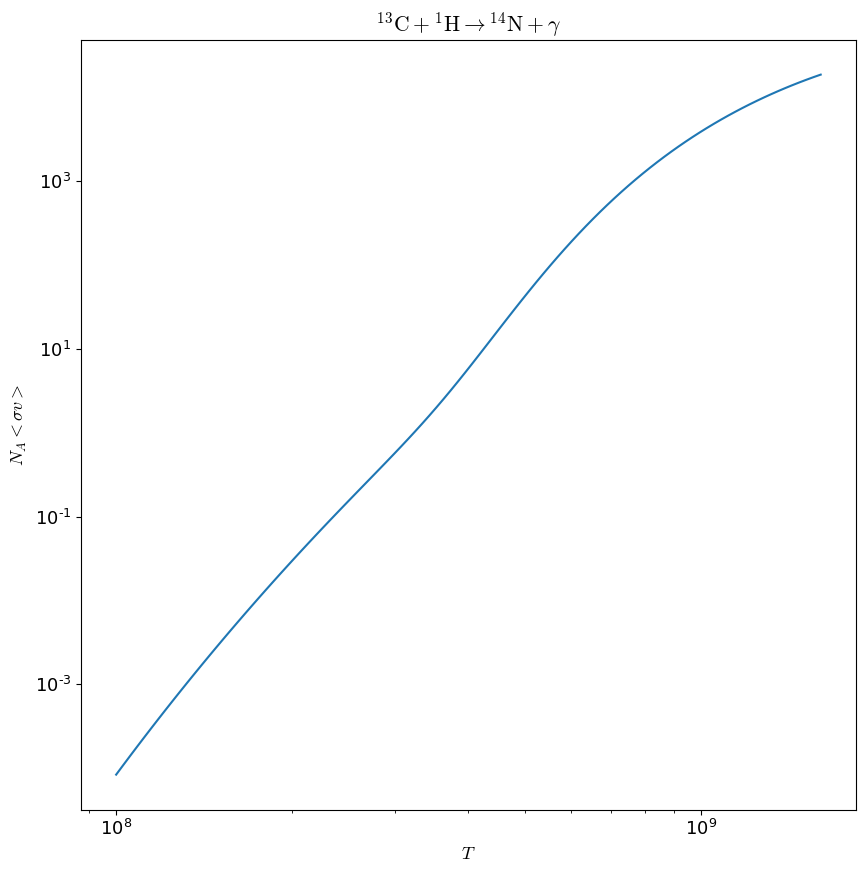

In [11]:
fig = c13pg.plot()

### density dependence

A rate also knows its density dependence -- this is inferred from the reactants in the rate description and is used to construct the terms needed to write a reaction network.  Note: since we want reaction rates per gram, this number is 1 less than the number of nuclei

In [12]:
c13pg.dens_exp

1

## Working with a group of rates

A `RateCollection()` class allows us to work with a group of rates.  This is used to explore their relationship.  Other classes (introduced soon) are built on this and will allow us to output network code directly.

Here we create a list with some of the individual rates in the ReacLib library

In [13]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]

rates = rl.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

Printing a rate collection shows all the rates

In [14]:
print(rc)

C12 + p ⟶ N13 + 𝛾
C13 + p ⟶ N14 + 𝛾
N13 ⟶ C13 + e⁺ + 𝜈
N13 + p ⟶ O14 + 𝛾
N14 + p ⟶ O15 + 𝛾
N15 + p ⟶ He4 + C12
O14 ⟶ N14 + e⁺ + 𝜈
O15 ⟶ N15 + e⁺ + 𝜈



More detailed information is provided by `network_overview()`

In [15]:
print(rc.network_overview())

p
  consumed by:
     C12 + p ⟶ N13 + 𝛾
     C13 + p ⟶ N14 + 𝛾
     N13 + p ⟶ O14 + 𝛾
     N14 + p ⟶ O15 + 𝛾
     N15 + p ⟶ He4 + C12
  produced by:

he4
  consumed by:
  produced by:
     N15 + p ⟶ He4 + C12

c12
  consumed by:
     C12 + p ⟶ N13 + 𝛾
  produced by:
     N15 + p ⟶ He4 + C12

c13
  consumed by:
     C13 + p ⟶ N14 + 𝛾
  produced by:
     N13 ⟶ C13 + e⁺ + 𝜈

n13
  consumed by:
     N13 ⟶ C13 + e⁺ + 𝜈
     N13 + p ⟶ O14 + 𝛾
  produced by:
     C12 + p ⟶ N13 + 𝛾

n14
  consumed by:
     N14 + p ⟶ O15 + 𝛾
  produced by:
     C13 + p ⟶ N14 + 𝛾
     O14 ⟶ N14 + e⁺ + 𝜈

n15
  consumed by:
     N15 + p ⟶ He4 + C12
  produced by:
     O15 ⟶ N15 + e⁺ + 𝜈

o14
  consumed by:
     O14 ⟶ N14 + e⁺ + 𝜈
  produced by:
     N13 + p ⟶ O14 + 𝛾

o15
  consumed by:
     O15 ⟶ N15 + e⁺ + 𝜈
  produced by:
     N14 + p ⟶ O15 + 𝛾




### show a network diagram

We visualize the network using NetworkX.  By default, this does not show H or He unless we have H + H or triple-alpha reactions in the network.  This is intended to reduce clutter.

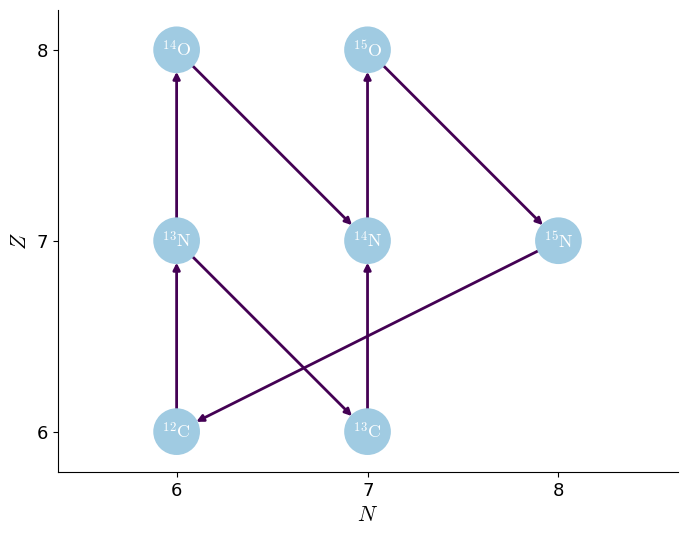

In [16]:
rc.plot()

There are many options that can be used to configure this plot, for instance, creating a rotated version (useful for very large nets).

## Explore the network's rates

To evaluate the rates, we need a composition

In [17]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

Interactive exploration is enabled through the `Explorer` class, which takes a `RateCollection` and a `Composition`

In [18]:
re = pyna.Explorer(rc, comp)
re.explore()

interactive(children=(FloatSlider(value=4.0, description='logrho', max=6.0, min=2.0), FloatSlider(value=8.0, d…